In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"


from crispr_millipede import encoding as cme
from crispr_millipede import modelling as cmm

import pandas as pd
import numpy as np

from Bio import SeqIO
from Bio.Seq import Seq

import matplotlib.pyplot as plt
import logomaker
import seaborn as sns
import matplotlib.patches as patches

In [2]:
amplicon = "ACATGCTCTAGTGAAAGCCAGTCTGGGCAGCTGGGTAGCTAATGAGGGGATTAGAGAGATTTTGTTGAATGAAAGGCAGATTGAGTCCTGCTACTCGCCCCCTTCATTCCCCTTCATTCATGCCTCATTCTTCCGCCTCCCAGCCGCCTCAACTGGCCAAAGGGAAGTGGAGGCCCTGCCACCTGTAGGGAGGGTCCCCTGGGGCTTGCCCACAGCAAACAGGAAGTCACAGCCTGGTGAGATGGGCCTGGGAATCAGCCACTGAGAAAGTGGGTCTCTTGGGTCCCTGAATTCTTTTTCTGAGTCCCTGCAGCAGTGAAAAAGACACAGAGGCACATAGAGAGTG"
print(f"Length of amplicon {len(amplicon)}")

Length of amplicon 346


In [3]:


design_matrix_spec = cmm.MillipedeDesignMatrixProcessingSpecification(
    wt_normalization=False,
    total_normalization=True,
    sigma_scale_normalized=True,
    decay_sigma_scale=True,
    K_enriched=5,
    K_baseline=5,
    a_parameter=0.0005,
    set_offset_as_presort = True,
    offset_normalized = False,
    offset_psuedocount = 1 # OTHERWISE will get infinity error when taking log(count +1) for offset, since 0 counts could be acceptable depending on thresholding
)

millipede_model_specification_set = {
    "joint_replicate_per_experiment_models" : cmm.MillipedeModelSpecification(
        model_types=[cmm.MillipedeModelType.NORMAL_SIGMA_SCALED, cmm.MillipedeModelType.NORMAL],
        replicate_merge_strategy=cmm.MillipedeReplicateMergeStrategy.COVARIATE,
        experiment_merge_strategy=cmm.MillipedeExperimentMergeStrategy.SEPARATE,
        S = 5,
        tau = 0.01,
        tau_intercept = 0.0001,
        cutoff_specification=cmm.MillipedeCutoffSpecification(
            per_replicate_each_condition_num_cutoff = 0, 
            per_replicate_all_condition_num_cutoff = 1, 
            all_replicate_num_cutoff = 0, 
            all_experiment_num_cutoff = 0,
            baseline_pop_all_condition_each_replicate_num_cutoff = 3,
            baseline_pop_all_condition_acceptable_rep_count = 2,
            enriched_pop_all_condition_each_replicate_num_cutoff = 3,
            enriched_pop_all_condition_acceptable_rep_count = 2,
            presort_pop_all_condition_each_replicate_num_cutoff = 3,
            presort_pop_all_condition_acceptable_rep_count = 2,
            
        ),
        design_matrix_processing_specification=design_matrix_spec
    )
}

In [4]:
paired_end_experiments_inputdata_denoised = cmm.MillipedeInputDataExperimentalGroup(
    data_directory="./", 
    enriched_pop_fn_experiment_list = ["20240816_v0_1_84_EvoCDA_encoding_dataframes_denoised_removed_ABE8e_encodings_rep{}.tsv"],
    enriched_pop_df_reads_colname = "#Reads_CD19minus",
    baseline_pop_fn_experiment_list = ["20240816_v0_1_84_EvoCDA_encoding_dataframes_denoised_removed_ABE8e_encodings_rep{}.tsv"],
    baseline_pop_df_reads_colname = "#Reads_CD19plus", 
    presort_pop_fn_experiment_list = ["20240816_v0_1_84_EvoCDA_encoding_dataframes_denoised_removed_ABE8e_encodings_rep{}.tsv"],
    presort_pop_df_reads_colname = '#Reads_presort',
    experiment_labels = ["EvoCDA"],
    reps = [0,1,2],
    millipede_model_specification_set = millipede_model_specification_set
   )


Performing initial input validation checks...
Passed validation.
Retrieving data for
	Replicate Merge Strategy: MillipedeReplicateMergeStrategy.COVARIATE 
	Experiment Merge Strategy MillipedeExperimentMergeStrategy.SEPARATE
	Cutoff: 
                    per_replicate_each_condition_num_cutoff=0, 
                    per_replicate_presort_condition_num_cutoff=0, 
                    per_replicate_all_condition_num_cutoff=1, 
                    all_replicate_num_cutoff=0, 
                    all_experiment_num_cutoff=0, 
                    baseline_pop_per_condition_acceptable_rep_count=0, 
                    baseline_pop_per_condition_acceptable_rep_count=0, 
                    baseline_pop_per_condition_acceptable_rep_count=0,
                    enriched_pop_per_condition_each_replicate_num_cutoff=0,
                    enriched_pop_per_condition_acceptable_rep_count=0,
                    presort_pop_per_condition_each_replicate_num_cutoff=0,
                    presort_pop_per_

## Run QC Tests 

In [5]:
data = paired_end_experiments_inputdata_denoised.millipede_model_specification_set_with_data['joint_replicate_per_experiment_models'][1].data[0]
data1 = data[data['intercept_exp0_rep0'] == 1]
data2 = data[data['intercept_exp0_rep1'] == 1]
data3 = data[data['intercept_exp0_rep2'] == 1]

print(data)
print(data1)
print(data2)
print(data3)

     intercept_exp0_rep0  intercept_exp0_rep1  intercept_exp0_rep2  24G>A  \
0                    1.0                  0.0                  0.0      0   
1                    1.0                  0.0                  0.0      0   
2                    1.0                  0.0                  0.0      0   
3                    1.0                  0.0                  0.0      0   
4                    1.0                  0.0                  0.0      0   
..                   ...                  ...                  ...    ...   
735                  0.0                  0.0                  1.0      0   
736                  0.0                  0.0                  1.0      0   
737                  0.0                  0.0                  1.0      0   
738                  0.0                  0.0                  1.0      0   
739                  0.0                  0.0                  1.0      1   

     25G>A  26G>A  27C>T  29G>A  30C>T  32G>A  ...  #Reads_CD19plus  \
0   

In [6]:
merged_encodings_millipede_rep0_rep1 = pd.merge(left=data1, right=data2, how="outer", on=[col for col in data2.columns if ">" in col], suffixes=("_rep0", "_rep1"))
merged_encodings_millipede_rep0_rep2 = pd.merge(left=data1, right=data3, how="outer", on=[col for col in data2.columns if ">" in col], suffixes=("_rep0", "_rep2"))
merged_encodings_millipede_rep1_rep2 = pd.merge(left=data2, right=data3, how="outer", on=[col for col in data2.columns if ">" in col], suffixes=("_rep1", "_rep2"))


/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/MilliV2/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


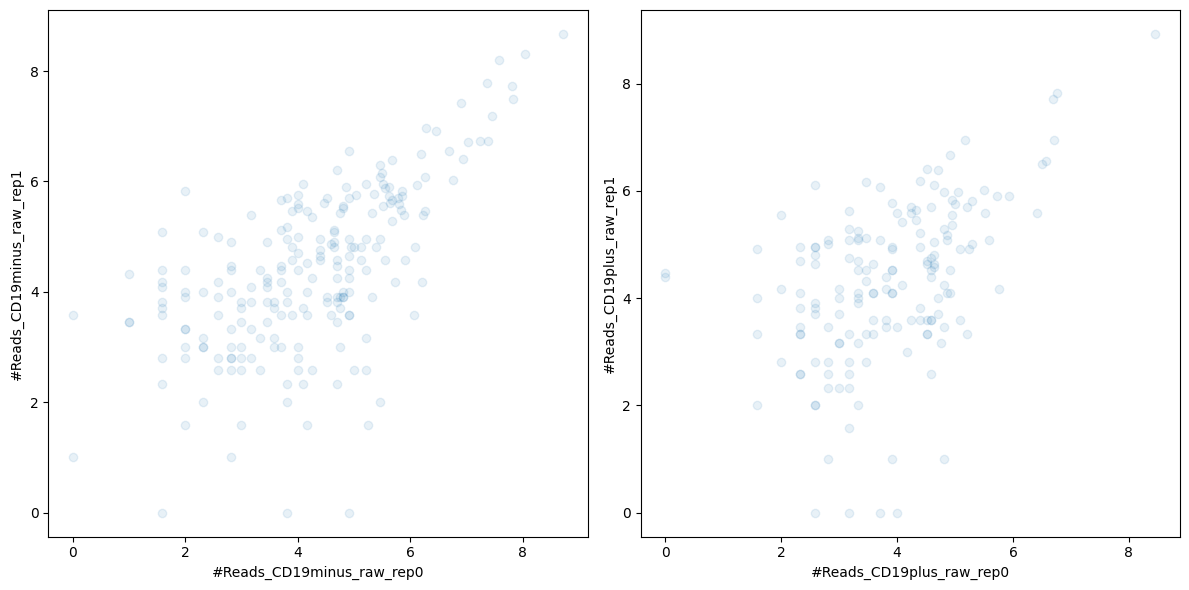

In [7]:
merged_encodings_millipede_rep0_rep1_minus_plus = merged_encodings_millipede_rep0_rep1[['#Reads_CD19minus_raw_rep0', '#Reads_CD19minus_raw_rep1', '#Reads_CD19plus_raw_rep0', '#Reads_CD19plus_raw_rep1',
                                                                                       '#Reads_CD19minus_rep0', '#Reads_CD19minus_rep1', '#Reads_CD19plus_rep0', '#Reads_CD19plus_rep1',
                                                                                       'score_rep0','score_rep1']]
merged_encodings_millipede_rep0_rep1_minus_plus = merged_encodings_millipede_rep0_rep1_minus_plus.dropna()
merged_encodings_millipede_rep0_rep1_minus_plus = merged_encodings_millipede_rep0_rep1_minus_plus.drop(merged_encodings_millipede_rep0_rep1_minus_plus.index[0])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first scatter plot
ax1.scatter(np.log2(merged_encodings_millipede_rep0_rep1_minus_plus['#Reads_CD19minus_raw_rep0']),
            np.log2(merged_encodings_millipede_rep0_rep1_minus_plus['#Reads_CD19minus_raw_rep1']),
            alpha=0.1)
ax1.set_xlabel('#Reads_CD19minus_raw_rep0')
ax1.set_ylabel('#Reads_CD19minus_raw_rep1')

# Plot the second scatter plot
ax2.scatter(np.log2(merged_encodings_millipede_rep0_rep1_minus_plus['#Reads_CD19plus_raw_rep0']),
            np.log2(merged_encodings_millipede_rep0_rep1_minus_plus['#Reads_CD19plus_raw_rep1']),
            alpha=0.1)
ax2.set_xlabel('#Reads_CD19plus_raw_rep0')
ax2.set_ylabel('#Reads_CD19plus_raw_rep1')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/MilliV2/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


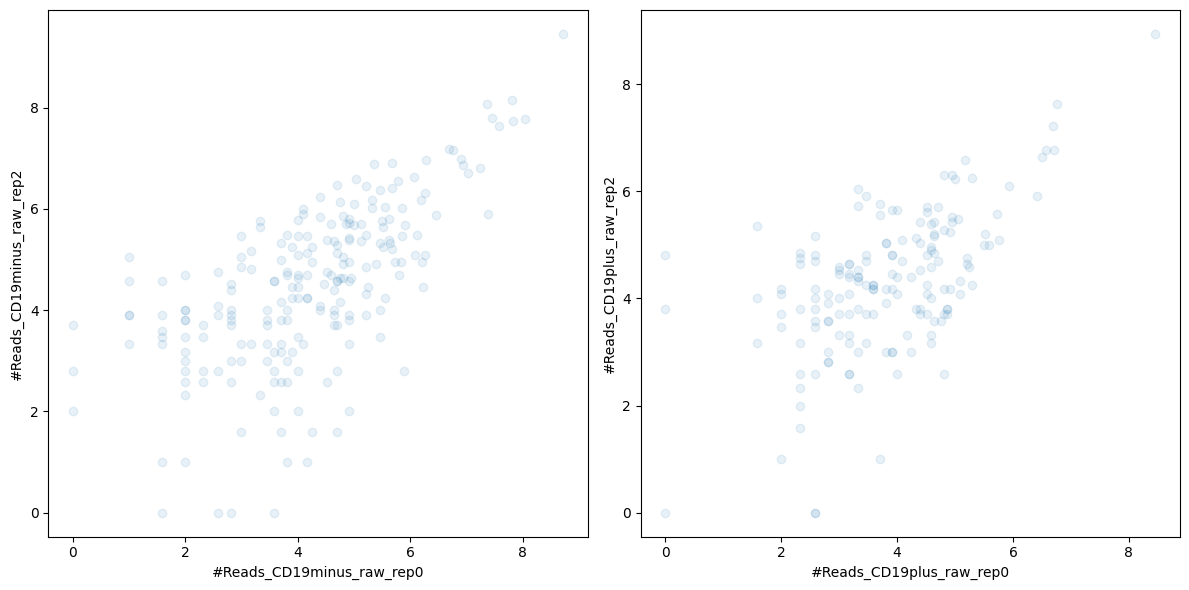

In [8]:
merged_encodings_millipede_rep0_rep2_minus_plus = merged_encodings_millipede_rep0_rep2[['#Reads_CD19minus_raw_rep0', '#Reads_CD19minus_raw_rep2', '#Reads_CD19plus_raw_rep0', '#Reads_CD19plus_raw_rep2',
                                                                                       '#Reads_CD19minus_rep0', '#Reads_CD19minus_rep2', '#Reads_CD19plus_rep0', '#Reads_CD19plus_rep2',
                                                                                       'score_rep0', 'score_rep2']]
merged_encodings_millipede_rep0_rep2_minus_plus = merged_encodings_millipede_rep0_rep2_minus_plus.dropna()
merged_encodings_millipede_rep0_rep2_minus_plus = merged_encodings_millipede_rep0_rep2_minus_plus.drop(merged_encodings_millipede_rep0_rep2_minus_plus.index[0])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first scatter plot
ax1.scatter(np.log2(merged_encodings_millipede_rep0_rep2_minus_plus['#Reads_CD19minus_raw_rep0']),
            np.log2(merged_encodings_millipede_rep0_rep2_minus_plus['#Reads_CD19minus_raw_rep2']),
            alpha=0.1)
ax1.set_xlabel('#Reads_CD19minus_raw_rep0')
ax1.set_ylabel('#Reads_CD19minus_raw_rep2')

# Plot the second scatter plot
ax2.scatter(np.log2(merged_encodings_millipede_rep0_rep2_minus_plus['#Reads_CD19plus_raw_rep0']),
            np.log2(merged_encodings_millipede_rep0_rep2_minus_plus['#Reads_CD19plus_raw_rep2']),
            alpha=0.1)
ax2.set_xlabel('#Reads_CD19plus_raw_rep0')
ax2.set_ylabel('#Reads_CD19plus_raw_rep2')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()


/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/MilliV2/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


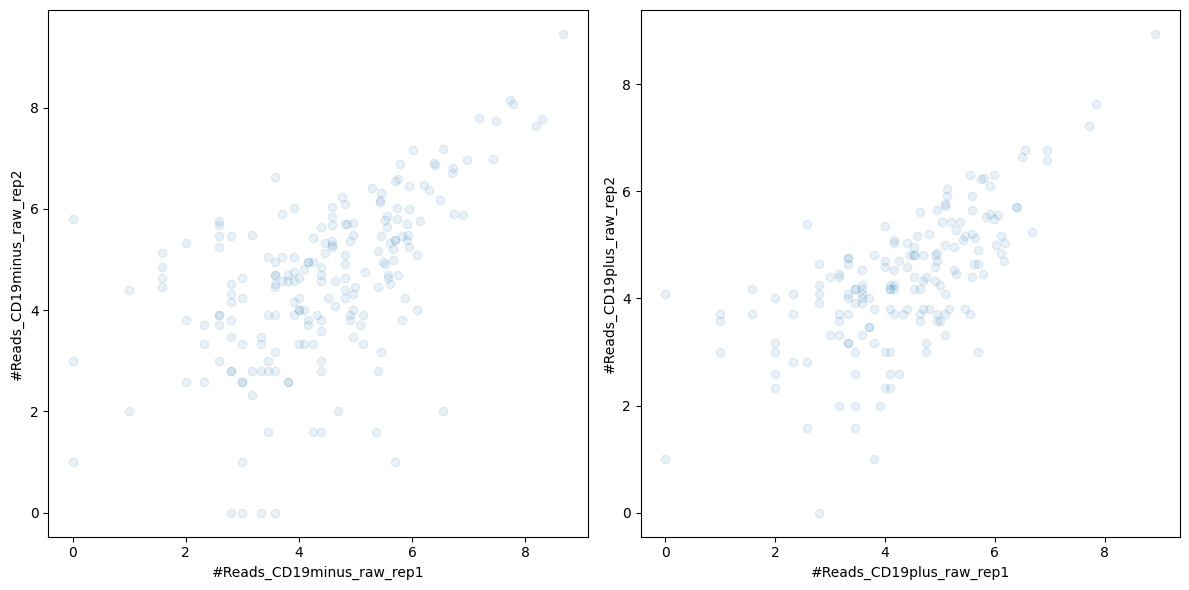

In [9]:
merged_encodings_millipede_rep1_rep2_minus_plus = merged_encodings_millipede_rep1_rep2[['#Reads_CD19minus_raw_rep1', '#Reads_CD19minus_raw_rep2', '#Reads_CD19plus_raw_rep1', '#Reads_CD19plus_raw_rep2',
                                                                                       '#Reads_CD19minus_rep1', '#Reads_CD19minus_rep2', '#Reads_CD19plus_rep1', '#Reads_CD19plus_rep2',
                                                                                       'score_rep1', 'score_rep2']]
merged_encodings_millipede_rep1_rep2_minus_plus = merged_encodings_millipede_rep1_rep2_minus_plus.dropna()
merged_encodings_millipede_rep1_rep2_minus_plus = merged_encodings_millipede_rep1_rep2_minus_plus.drop(merged_encodings_millipede_rep1_rep2_minus_plus.index[0])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first scatter plot
ax1.scatter(np.log2(merged_encodings_millipede_rep1_rep2_minus_plus['#Reads_CD19minus_raw_rep1']),
            np.log2(merged_encodings_millipede_rep1_rep2_minus_plus['#Reads_CD19minus_raw_rep2']),
            alpha=0.1)
ax1.set_xlabel('#Reads_CD19minus_raw_rep1')
ax1.set_ylabel('#Reads_CD19minus_raw_rep2')

# Plot the second scatter plot
ax2.scatter(np.log2(merged_encodings_millipede_rep1_rep2_minus_plus['#Reads_CD19plus_raw_rep1']),
            np.log2(merged_encodings_millipede_rep1_rep2_minus_plus['#Reads_CD19plus_raw_rep2']),
            alpha=0.1)
ax2.set_xlabel('#Reads_CD19plus_raw_rep1')
ax2.set_ylabel('#Reads_CD19plus_raw_rep2')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()


In [10]:
merged_encodings_millipede_rep0_rep1_minus_plus['NormSumRep0'] = merged_encodings_millipede_rep0_rep1_minus_plus['#Reads_CD19plus_rep0'] + merged_encodings_millipede_rep0_rep1_minus_plus['#Reads_CD19minus_rep0']
merged_encodings_millipede_rep0_rep1_minus_plus['NormSumRep1'] = merged_encodings_millipede_rep0_rep1_minus_plus['#Reads_CD19plus_rep1'] + merged_encodings_millipede_rep0_rep1_minus_plus['#Reads_CD19minus_rep1']
merged_encodings_millipede_rep0_rep2_minus_plus['NormSumRep2'] = merged_encodings_millipede_rep0_rep2_minus_plus['#Reads_CD19plus_rep2'] + merged_encodings_millipede_rep0_rep2_minus_plus['#Reads_CD19minus_rep2']



/tmp/ipykernel_194661/2529737909.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.cut(df['NormSumRep0'], bins)


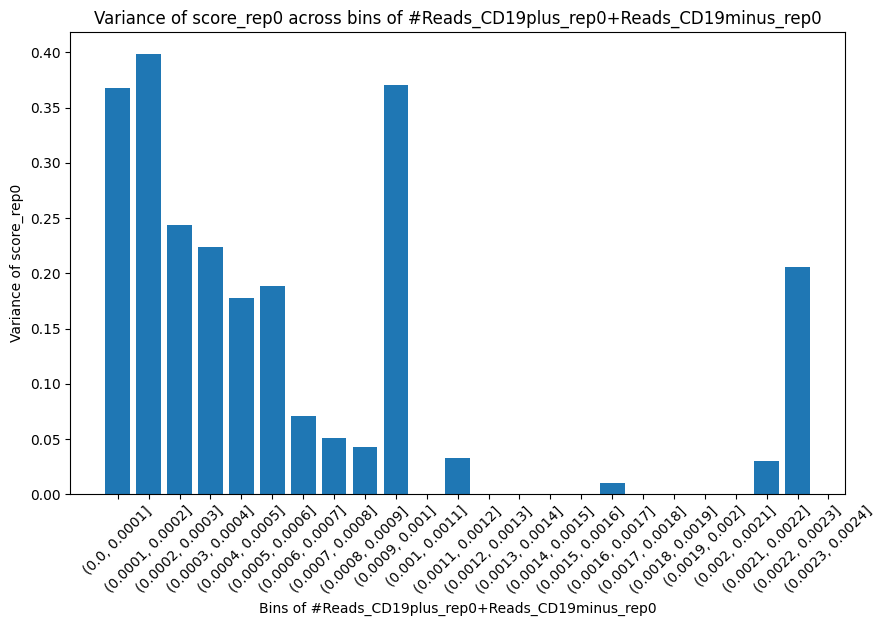

In [11]:
df = merged_encodings_millipede_rep0_rep1_minus_plus[['NormSumRep0', 'score_rep0']]

# Create bins
bin_width = 0.0001  # You can adjust this to 0.0005 or another value as needed
bins = np.arange(0, 0.005 + bin_width, bin_width)  # Create bins from 0 to 0.005 with the specified width

df['bins'] = pd.cut(df['NormSumRep0'], bins)

# Compute variance for each bin
variance_per_bin = df.groupby('bins')['score_rep0'].var().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(variance_per_bin['bins'].astype(str), variance_per_bin['score_rep0'], width=0.8)
plt.xlabel('Bins of #Reads_CD19plus_rep0+Reads_CD19minus_rep0')
plt.ylabel('Variance of score_rep0')
plt.title('Variance of score_rep0 across bins of #Reads_CD19plus_rep0+Reads_CD19minus_rep0')
plt.xticks(rotation=45)
plt.show()


/tmp/ipykernel_194661/1520270563.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.cut(df['NormSumRep1'], bins)


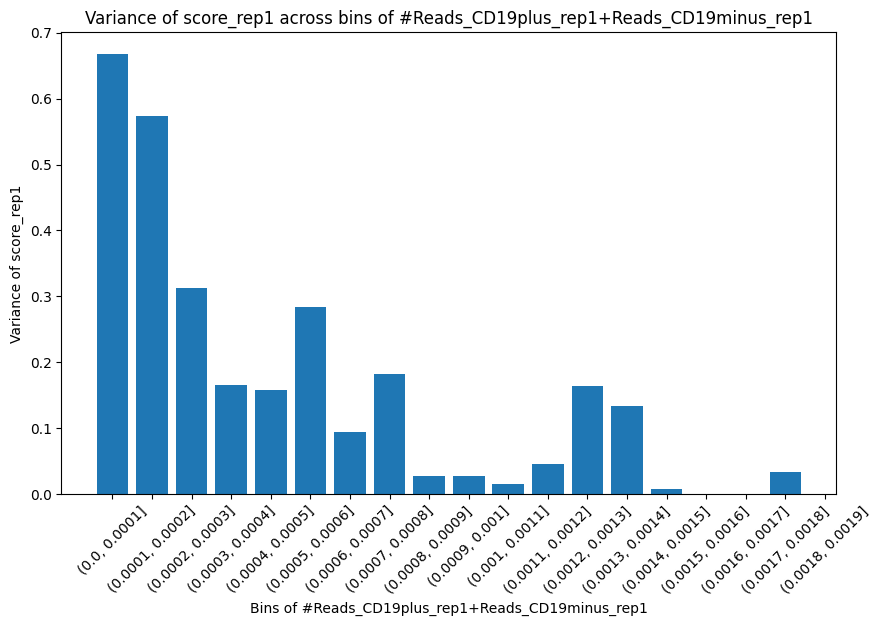

In [12]:
df = merged_encodings_millipede_rep0_rep1_minus_plus[['NormSumRep1', 'score_rep1']]

# Create bins
bin_width = 0.0001  # You can adjust this to 0.0005 or another value as needed
bins = np.arange(0, 0.005 + bin_width, bin_width)  # Create bins from 0 to 0.005 with the specified width

df['bins'] = pd.cut(df['NormSumRep1'], bins)

# Compute variance for each bin
variance_per_bin = df.groupby('bins')['score_rep1'].var().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(variance_per_bin['bins'].astype(str), variance_per_bin['score_rep1'], width=0.8)
plt.xlabel('Bins of #Reads_CD19plus_rep1+Reads_CD19minus_rep1')
plt.ylabel('Variance of score_rep1')
plt.title('Variance of score_rep1 across bins of #Reads_CD19plus_rep1+Reads_CD19minus_rep1')
plt.xticks(rotation=45)
plt.show()


/tmp/ipykernel_194661/2244873421.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins'] = pd.cut(df['NormSumRep2'], bins)


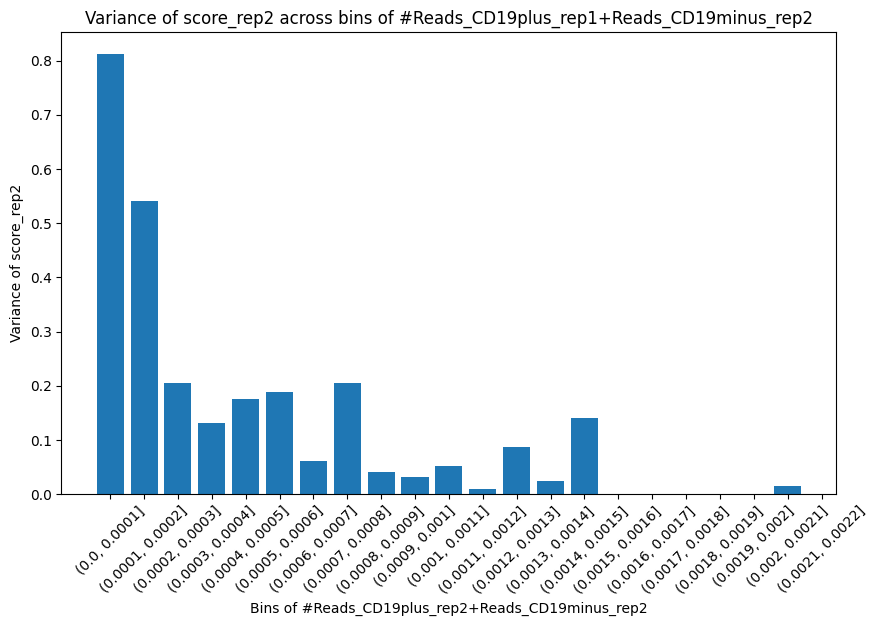

In [13]:
df = merged_encodings_millipede_rep0_rep2_minus_plus[['NormSumRep2', 'score_rep2']]

# Create bins
bin_width = 0.0001  # You can adjust this to 0.0005 or another value as needed
bins = np.arange(0, 0.005 + bin_width, bin_width)  # Create bins from 0 to 0.005 with the specified width

df['bins'] = pd.cut(df['NormSumRep2'], bins)

# Compute variance for each bin
variance_per_bin = df.groupby('bins')['score_rep2'].var().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(variance_per_bin['bins'].astype(str), variance_per_bin['score_rep2'], width=0.8)
plt.xlabel('Bins of #Reads_CD19plus_rep2+Reads_CD19minus_rep2')
plt.ylabel('Variance of score_rep2')
plt.title('Variance of score_rep2 across bins of #Reads_CD19plus_rep1+Reads_CD19minus_rep2')
plt.xticks(rotation=45)
plt.show()


In [14]:
def collapse_columns(df):
    
    df_a = df.copy()
    df_b = df.copy()
    df_c = df.copy()
    
    # Populate the reads column
    df_a['reads'] = df_a['#Reads_CD19minus_raw']
    df_b['reads'] = df_b['#Reads_CD19plus_raw']
    df_c['reads'] = df_c['#Reads_presort_raw']
    
    #Create indicator columns
    df_a['Minus'] = 1
    df_a['Plus'] = 0
    df_a['Presort'] = 0
    
    df_b['Minus'] = 0
    df_b['Plus'] = 1
    df_b['Presort'] = 0
    
    df_c['Minus'] = 0
    df_c['Plus'] = 0
    df_c['Presort'] = 1
    
    result_df = pd.concat([df_a, df_b, df_c], ignore_index = True)
    

    
    return result_df


In [15]:
dataCollapsed1 = collapse_columns(data1)
dataCollapsed2 = collapse_columns(data2)
dataCollapsed3 = collapse_columns(data3)
dataCollapsed3

,intercept_exp0_rep0,intercept_exp0_rep1,intercept_exp0_rep2,24G>A,25G>A,26G>A,27C>T,29G>A,30C>T,32G>A,...,#Reads_CD19minus_raw,#Reads_CD19plus_raw,#Reads_presort_raw,score,scale_factor,psi0,reads,Minus,Plus,Presort
0,0.0,0.0,1.0,0,0,0,0,0,0,0,...,96514.0,109542.0,106490.0,-0.020335,1.000000,11.575816,96514.0,1,0,0
1,0.0,0.0,1.0,0,0,0,0,0,0,0,...,24.0,16.0,9.0,0.240877,1.799833,2.302585,24.0,1,0,0
2,0.0,0.0,1.0,0,0,0,0,0,0,0,...,14.0,23.0,7.0,-0.202412,1.904556,2.079442,14.0,1,0,0
3,0.0,0.0,1.0,0,0,0,0,0,0,0,...,2.0,9.0,2.0,-0.610091,3.651028,1.098612,2.0,1,0,0
4,0.0,0.0,1.0,0,0,0,0,0,0,0,...,26.0,17.0,7.0,0.250001,1.717740,2.079442,26.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,0.0,0.0,1.0,0,0,1,0,0,0,0,...,8.0,5.0,6.0,0.271029,3.333304,1.945910,6.0,0,0,1
725,0.0,0.0,1.0,0,1,0,0,0,0,0,...,19.0,28.0,18.0,-0.149775,1.591813,2.944439,18.0,0,0,1
726,0.0,0.0,1.0,0,1,1,0,0,0,0,...,2.0,2.0,3.0,0.042946,4.382873,1.386294,3.0,0,0,1
727,0.0,0.0,1.0,0,1,1,0,0,0,0,...,4.0,5.0,0.0,-0.068492,3.749270,0.000000,0.0,0,0,1


In [16]:
final_df = pd.concat([dataCollapsed1, dataCollapsed2, dataCollapsed3], ignore_index = True)
final_df

,intercept_exp0_rep0,intercept_exp0_rep1,intercept_exp0_rep2,24G>A,25G>A,26G>A,27C>T,29G>A,30C>T,32G>A,...,#Reads_CD19minus_raw,#Reads_CD19plus_raw,#Reads_presort_raw,score,scale_factor,psi0,reads,Minus,Plus,Presort
0,1.0,0.0,0.0,0,0,0,0,0,0,0,...,91592.0,83349.0,102375.0,-0.017141,1.000000,11.536408,91592.0,1,0,0
1,1.0,0.0,0.0,0,0,0,0,0,0,0,...,12.0,8.0,13.0,0.137558,2.513893,2.639057,12.0,1,0,0
2,1.0,0.0,0.0,0,0,0,0,0,0,0,...,7.0,21.0,11.0,-0.546658,2.260483,2.484907,7.0,1,0,0
3,1.0,0.0,0.0,0,0,0,0,0,0,0,...,4.0,3.0,1.0,0.079377,3.835318,0.693147,4.0,1,0,0
4,1.0,0.0,0.0,0,0,0,0,0,0,0,...,4.0,7.0,8.0,-0.331137,3.333073,2.197225,4.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2215,0.0,0.0,1.0,0,0,1,0,0,0,0,...,8.0,5.0,6.0,0.271029,3.333304,1.945910,6.0,0,0,1
2216,0.0,0.0,1.0,0,1,0,0,0,0,0,...,19.0,28.0,18.0,-0.149775,1.591813,2.944439,18.0,0,0,1
2217,0.0,0.0,1.0,0,1,1,0,0,0,0,...,2.0,2.0,3.0,0.042946,4.382873,1.386294,3.0,0,0,1
2218,0.0,0.0,1.0,0,1,1,0,0,0,0,...,4.0,5.0,0.0,-0.068492,3.749270,0.000000,0.0,0,0,1


In [17]:
nt_columns = [col for col in final_df.columns if ">" in col]
final_df['Covariate_ID'] = final_df[nt_columns].astype(str).agg('_'.join, axis = 1)
final_df

,intercept_exp0_rep0,intercept_exp0_rep1,intercept_exp0_rep2,24G>A,25G>A,26G>A,27C>T,29G>A,30C>T,32G>A,...,#Reads_CD19plus_raw,#Reads_presort_raw,score,scale_factor,psi0,reads,Minus,Plus,Presort,Covariate_ID
0,1.0,0.0,0.0,0,0,0,0,0,0,0,...,83349.0,102375.0,-0.017141,1.000000,11.536408,91592.0,1,0,0,0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_...
1,1.0,0.0,0.0,0,0,0,0,0,0,0,...,8.0,13.0,0.137558,2.513893,2.639057,12.0,1,0,0,0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_...
2,1.0,0.0,0.0,0,0,0,0,0,0,0,...,21.0,11.0,-0.546658,2.260483,2.484907,7.0,1,0,0,0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_...
3,1.0,0.0,0.0,0,0,0,0,0,0,0,...,3.0,1.0,0.079377,3.835318,0.693147,4.0,1,0,0,0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_...
4,1.0,0.0,0.0,0,0,0,0,0,0,0,...,7.0,8.0,-0.331137,3.333073,2.197225,4.0,1,0,0,0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2215,0.0,0.0,1.0,0,0,1,0,0,0,0,...,5.0,6.0,0.271029,3.333304,1.945910,6.0,0,0,1,0_0_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_...
2216,0.0,0.0,1.0,0,1,0,0,0,0,0,...,28.0,18.0,-0.149775,1.591813,2.944439,18.0,0,0,1,0_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_...
2217,0.0,0.0,1.0,0,1,1,0,0,0,0,...,2.0,3.0,0.042946,4.382873,1.386294,3.0,0,0,1,0_1_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_...
2218,0.0,0.0,1.0,0,1,1,0,0,0,0,...,5.0,0.0,-0.068492,3.749270,0.000000,0.0,0,0,1,0_1_1_0_0_0_0_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_...


In [18]:
# Step 1: Melt the dataframe to convert replicate indicators into a long format
melted_df = final_df.melt(id_vars=['Covariate_ID', '#Reads_CD19minus_raw', '#Reads_CD19plus_raw', '#Reads_presort_raw'], 
                          value_vars=['intercept_exp0_rep0', 'intercept_exp0_rep1', 'intercept_exp0_rep2'],
                          var_name='replicate', value_name='rep_value')

# Filter out rows where rep_value is 0
melted_df = melted_df[melted_df['rep_value'] == 1]

pivoted_df = melted_df.pivot_table(index='Covariate_ID', columns='replicate', 
                                   values=['#Reads_CD19minus_raw', '#Reads_CD19plus_raw', '#Reads_presort_raw'])



pivoted_df


#Reads_CD19minus_raw  \
replicate                                           intercept_exp0_rep0   
Covariate_ID                                                              
0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...              91592.0   
0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                 12.0   
0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                  7.0   
0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                  4.0   
0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                  4.0   
...                                                                 ...   
0_0_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                  7.0   
0_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                 18.0   
0_1_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                  3.0   
0_1_1_0_0_0_0_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                  1.0   
1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                 27.0   

                                                                        \
replicate                                          intercept_exp0_rep1   
Covariate_ID                                                             
0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...             88047.0   
0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                13.0   
0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                 7.0   
0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                 8.0   
0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                21.0   
...                                                                ...   
0_0_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                21.0   
0_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                16.0   
0_1_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                 1.0   
0_1_1_0_0_0_0_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                 2.0   
1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                15.0   

                                                                        \
replicate                                          intercept_exp0_rep2   
Covariate_ID                                                             
0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...             96514.0   
0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                24.0   
0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                14.0   
0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                 2.0   
0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                26.0   
...                                                                ...   
0_0_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                 8.0   
0_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                19.0   
0_1_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                 2.0   
0_1_1_0_0_0_0_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                 4.0   
1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                18.0   

                                                   #Reads_CD19plus_raw  \
replicate                                          intercept_exp0_rep0   
Covariate_ID                                                             
0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...             83349.0   
0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                 8.0   
0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                21.0   
0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                 3.0   
0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                 7.0   
...                                                                ...   
0_0_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                10.0   
0_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                11.0   
0_1_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0...                 4.0   
0_1_1_0_0_0_0_1_0_0_0_0_0_0_0_0_0_0_0_

In [19]:
# Flatten the multi-level columns
pivoted_df.columns = [f'{var}rep{rep}' for var, rep in pivoted_df.columns]

# Reset index to get Covariate_ID back as a column
pivoted_df.reset_index(inplace=True)

pivoted_df = pivoted_df.fillna(0)

# Create a mask where all values in the row are greater than 0
#mask = (pivoted_df.iloc[:, 1:] > 0).all(axis=1)

# Apply the mask to keep only rows where all columns have a value > 0
#pivoted_df = pivoted_df[mask]

#mask = (pivoted_df.iloc[:, 7:] > 50).all(axis=1) #PRESORT > 10
#pivoted_df = pivoted_df[mask]



pivoted_df

,Covariate_ID,#Reads_CD19minus_rawrepintercept_exp0_rep0,#Reads_CD19minus_rawrepintercept_exp0_rep1,#Reads_CD19minus_rawrepintercept_exp0_rep2,#Reads_CD19plus_rawrepintercept_exp0_rep0,#Reads_CD19plus_rawrepintercept_exp0_rep1,#Reads_CD19plus_rawrepintercept_exp0_rep2,#Reads_presort_rawrepintercept_exp0_rep0,#Reads_presort_rawrepintercept_exp0_rep1,#Reads_presort_rawrepintercept_exp0_rep2
0,0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_...,91592.0,88047.0,96514.0,83349.0,117273.0,109542.0,102375.0,61906.0,106490.0
1,0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_...,12.0,13.0,24.0,8.0,13.0,16.0,13.0,5.0,9.0
2,0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_...,7.0,7.0,14.0,21.0,12.0,23.0,11.0,9.0,7.0
3,0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_...,4.0,8.0,2.0,3.0,4.0,9.0,1.0,3.0,2.0
4,0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_...,4.0,21.0,26.0,7.0,34.0,17.0,8.0,5.0,7.0
...,...,...,...,...,...,...,...,...,...,...
259,0_0_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_...,7.0,21.0,8.0,10.0,17.0,5.0,10.0,7.0,6.0
260,0_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_...,18.0,16.0,19.0,11.0,23.0,28.0,22.0,8.0,18.0
261,0_1_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_...,3.0,1.0,2.0,4.0,0.0,2.0,5.0,2.0,3.0
262,0_1_1_0_0_0_0_1_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_...,1.0,2.0,4.0,0.0,4.0,5.0,0.0,0.0,0.0


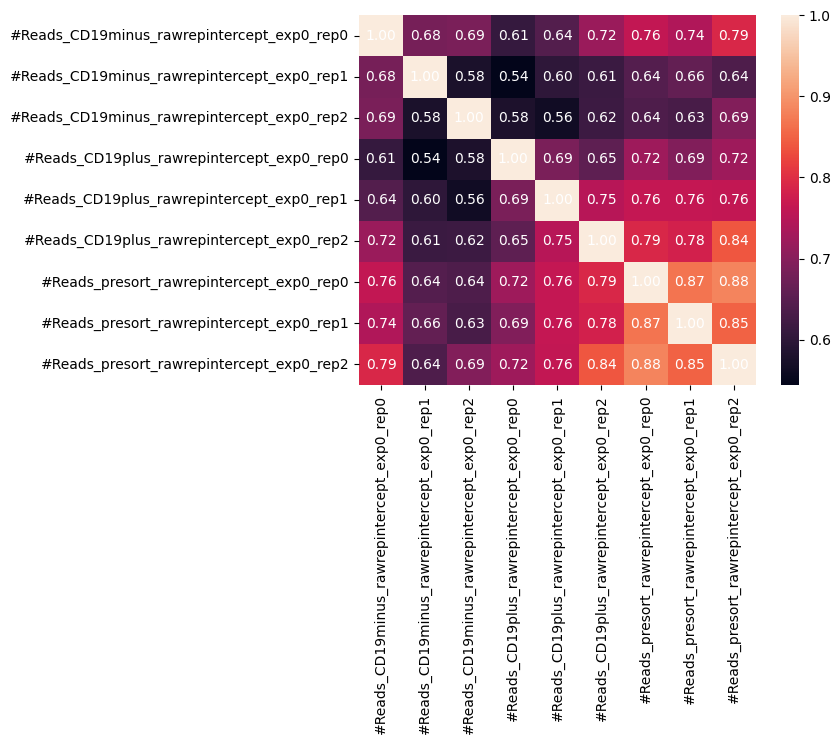

In [20]:
#Non Normalized Correlation Heatmap
import seaborn as sns

count_columns = [col for col in pivoted_df.columns if 'Reads' in col]
counts_df = pivoted_df[count_columns].transpose()

corr_df1 = counts_df.T.corr(method='spearman')


ax = sns.heatmap(corr_df1, annot=False)

# Loop over the data dimensions and create text annotations.
for i in range(corr_df1.shape[0]):
    for j in range(corr_df1.shape[1]):
        ax.text(j + 0.5, i + 0.5, 
                f'{corr_df1.iloc[i, j]:.2f}',  # Format the annotation as desired
                ha='center', va='center', color='white')

plt.show()



## Run Millipede

In [21]:
%%time
from crispr_millipede import encoding as cme
from crispr_millipede import modelling as cmm

paired_end_experiments_models_denoised = cmm.MillipedeModelExperimentalGroup(experiments_inputdata=paired_end_experiments_inputdata_denoised, device=cmm.MillipedeComputeDevice.GPU)


Start model inference for all provided model specifications: 1 total
Starting model inference for model specification id 1/1: joint_replicate_per_experiment_models
Number of single matrices: 1
With 2 model types, the total models to inference for this model specification: 2
Running model(s) for single matrix index: 1/1
Iterating through all 2 provided models: 
Preparing data for model NORMAL_SIGMA_SCALED, 1/2
Running model NORMAL_SIGMA_SCALED


  0%|          | 0/5500 [00:00<?, ?it/s]

Preparing data for model NORMAL, 2/2
Running model NORMAL


  0%|          | 0/5500 [00:00<?, ?it/s]

CPU times: user 37.6 s, sys: 1.12 s, total: 38.8 s
Wall time: 36.3 s


In [22]:
beta_df = paired_end_experiments_models_denoised.millipede_model_specification_set_with_results['joint_replicate_per_experiment_models'].millipede_model_specification_result_input[0].millipede_model_specification_single_matrix_result[cmm.MillipedeModelType.NORMAL_SIGMA_SCALED].beta
pip_df = paired_end_experiments_models_denoised.millipede_model_specification_set_with_results['joint_replicate_per_experiment_models'].millipede_model_specification_result_input[0].millipede_model_specification_single_matrix_result[cmm.MillipedeModelType.NORMAL_SIGMA_SCALED].pip
display(beta_df.sort_values(ascending=False).head(40))
display(pip_df.sort_values(ascending=False).head(40))

154G>A                 0.286087
229C>T                 0.237312
201G>A                 0.197833
Intercept              0.182835
227C>T                 0.168180
214G>A                 0.051890
202G>A                 0.042340
184G>A                 0.032744
221G>A                 0.020744
174C>T                 0.013155
140C>T                 0.011269
134G>A                 0.010806
238G>A                 0.007394
173C>T                 0.007387
166G>A                 0.006325
181C>T                 0.005828
intercept_exp0_rep2    0.005613
132C>T                 0.003106
intercept_exp0_rep0    0.002901
122C>T                 0.002624
27C>T                  0.002447
188G>A                 0.002446
139C>T                 0.001934
222G>A                 0.001899
149C>T                 0.001897
231G>A                 0.001896
203G>A                 0.001601
182C>T                 0.001589
200G>A                 0.001293
135C>T                 0.001137
172G>A                 0.001114
143C>T  

154G>A    0.999483
229C>T    0.604585
201G>A    0.507877
227C>T    0.452323
214G>A    0.186432
202G>A    0.084972
221G>A    0.078122
174C>T    0.067847
184G>A    0.057568
173C>T    0.045525
271G>A    0.036018
238G>A    0.031991
29G>A     0.031958
24G>A     0.028416
134G>A    0.027668
140C>T    0.025712
208C>T    0.019105
181C>T    0.017520
111C>T    0.016229
108C>T    0.015374
149C>T    0.015124
109C>T    0.014503
166G>A    0.014470
132C>T    0.014301
259C>T    0.013613
188G>A    0.012557
139C>T    0.012466
231G>A    0.012051
263G>A    0.011061
269G>A    0.010744
200G>A    0.010643
27C>T     0.010591
122C>T    0.010175
34G>A     0.009833
197C>T    0.009379
210C>T    0.009088
169G>A    0.008643
261C>T    0.008549
204C>T    0.008308
196C>T    0.008239
Name: PIP, dtype: float64

In [118]:
paired_merged_raw_encodings = cmm.RawEncodingDataframesExperimentalGroup().read_in_files_constructor(
    enriched_pop_fn_encodings_experiment_list=["./20240816_v0_1_84_EvoCDA_encoding_dataframes_denoised_removed_CD19minus_ABE8e_encodings_rep{}.pkl"],
    baseline_pop_fn_encodings_experiment_list=["./20240816_v0_1_84_EvoCDA_encoding_dataframes_denoised_removed_CD19plus_ABE8e_encodings_rep{}.pkl"], 
    presort_pop_fn_encodings_experiment_list=["./20240816_v0_1_84_EvoCDA_encoding_dataframes_denoised_removed_presort_ABE8e_encodings_rep{}.pkl"],
    experiment_labels=["EvoCDA"],
    ctrl_pop_fn_encodings="./20240816_v0_1_84_EvoCDA_encoding_dataframes_denoised_removed_wt_encodings_rep0.pkl",
    ctrl_pop_labels="WT",
    reps=[0,1,2])
paired_merged_raw_encodings_editing_freqs = cmm.EncodingEditingFrequenciesExperimentalGroup(paired_merged_raw_encodings)

['./20240816_v0_1_84_EvoCDA_encoding_dataframes_denoised_removed_CD19minus_ABE8e_encodings_rep{}.pkl']
Reading enriched population...
Reading baseline population...
Reading presort population if provided...
Reading control population if provided...
Passed post-validation
ctrl_pop_encoding_editing_freq_avg_level was set to max depth of ctrl_pop_encodings_df_list, so no average was calculated
ctrl_pop_encoding_editing_freq_avg_level was set to max depth of ctrl_pop_encodings_df_list, so no average was calculated


In [82]:
# paired_merged_raw_encodings = cmm.RawEncodingDataframesExperimentalGroup().read_in_files_constructor(
#     enriched_pop_fn_encodings_experiment_list=["./20240901_v0_1_89_EvoCDA_encoding_dataframes_denoised_nonposition_nontrimmed_removed_CD19minus_ABE8e_encodings_rep{}.pkl"],
#     baseline_pop_fn_encodings_experiment_list=["./20240901_v0_1_89_EvoCDA_encoding_dataframes_denoised_nonposition_nontrimmed_removed_CD19plus_ABE8e_encodings_rep{}.pkl"], 
#     presort_pop_fn_encodings_experiment_list=["./20240901_v0_1_89_EvoCDA_encoding_dataframes_denoised_nonposition_nontrimmed_removed_presort_ABE8e_encodings_rep{}.pkl"],
#     experiment_labels=["EvoCDA"],
#     ctrl_pop_fn_encodings="./20240901_v0_1_89_EvoCDA_encoding_dataframes_denoised_nonposition_nontrimmed_removed_wt_encodings_rep0.pkl",
#     ctrl_pop_labels="WT",
#     reps=[0,1,2])
# paired_merged_raw_encodings_editing_freqs = cmm.EncodingEditingFrequenciesExperimentalGroup(paired_merged_raw_encodings)

In [119]:
paired_merged_raw_encodings_editing_freqs.presort_pop_encoding_editing_per_variant_freq_avg[0].to_csv('presort_editing_freqs_avg_evoCDA_1_89.csv')
paired_merged_raw_encodings_editing_freqs.baseline_pop_encoding_editing_per_variant_freq_avg[0].to_csv('baseline_editing_freqs_avg_evoCDA_1_89.csv')
paired_merged_raw_encodings_editing_freqs.enriched_pop_encoding_editing_per_variant_freq_avg[0].to_csv('enriched_editing_freqs_avg_evoCDA_1_89.csv')
paired_merged_raw_encodings_editing_freqs.ctrl_pop_encoding_editing_per_variant_freq_avg[0].to_csv('wt_editing_freqs_avg_evoCDA_1_89.csv')

In [120]:
sigma_hit_table = paired_end_experiments_models_denoised.millipede_model_specification_set_with_results["joint_replicate_per_experiment_models"].millipede_model_specification_result_input[0].millipede_model_specification_single_matrix_result[cmm.MillipedeModelType.NORMAL_SIGMA_SCALED].summary
sigma_hit_table.to_csv('CD19_evoCDA_sigma_hit_table_ZP.csv', index=True)
sigma_hit_table

,PIP,Coefficient,Coefficient StdDev,Conditional Coefficient,Conditional Coefficient StdDev
24G>A,0.028416,-0.011663,0.069974,-0.328111,0.184160
25G>A,0.006584,-0.000977,0.020014,-0.149845,0.197826
26G>A,0.005223,-0.000565,0.024931,-0.053036,0.235704
27C>T,0.010591,0.002447,0.022295,0.171936,0.076095
29G>A,0.031958,-0.018400,0.102294,-0.459131,0.242402
...,...,...,...,...,...
272G>A,0.005834,0.000517,0.022364,0.060438,0.234307
intercept_exp0_rep0,NaN,0.002901,0.027327,0.002901,0.027327
intercept_exp0_rep1,NaN,-0.007188,0.027394,-0.007188,0.027394
intercept_exp0_rep2,NaN,0.005613,0.028612,0.005613,0.028612


In [121]:
normal_hit_table = paired_end_experiments_models_denoised.millipede_model_specification_set_with_results["joint_replicate_per_experiment_models"].millipede_model_specification_result_input[0].millipede_model_specification_single_matrix_result[cmm.MillipedeModelType.NORMAL].summary
normal_hit_table.to_csv('CD19_evoCDA_normal_hit_table_ZP.csv', index=True)

In [5]:
def millipede_dataframe_cleanup(path):

    millipede_dataframe = pd.read_csv(path, index_col = 0)
    millipede_dataframe.reset_index(drop=False, inplace=True)

    #CleanUp dataframe

    millipede_dataframe[['MainIndex','Base','Waste','BaseChange']] = millipede_dataframe['index'].str.extract('(^\d+)([A-Z])([->|-])([-]|[A-Z])')
    # millipede_dataframe = millipede_dataframe.dropna()
    millipede_dataframe['BaseChange'] = millipede_dataframe.apply(lambda x: x['Base'] if x['BaseChange']=="-" else x['BaseChange'], axis=1)
    millipede_dataframe['FinalIndex'] = millipede_dataframe['MainIndex'] + millipede_dataframe['Base']
    millipede_dataframe = millipede_dataframe[millipede_dataframe['BaseChange'] != 'N']


    #Generate Betas dataframe
    millipede_dataframe_Betas = millipede_dataframe[['FinalIndex','BaseChange','Coefficient','MainIndex','Base']]
    millipede_dataframe_Betas['MainIndex'] = millipede_dataframe_Betas['MainIndex'].astype(float)
    millipede_dataframe_Betas = millipede_dataframe_Betas.sort_values(by='MainIndex', ascending=True)


    #Generate PIPS dataframe
    millipede_dataframe_PIPS = millipede_dataframe[['FinalIndex','BaseChange','PIP','MainIndex','Base']]
    millipede_dataframe_PIPS['MainIndex'] = millipede_dataframe['MainIndex'].astype(float)
    millipede_dataframe_PIPS = millipede_dataframe_PIPS.sort_values(by='MainIndex', ascending=True)

    #Pivot the Betas dataframe
    
    millipede_dataframe_Betas_pivot = millipede_dataframe_Betas.pivot_table(values='Coefficient', index='BaseChange', columns=['MainIndex','Base'])
    millipede_dataframe_Betas_pivot = millipede_dataframe_Betas_pivot.replace(-9999, np.nan)

    for column in millipede_dataframe_Betas_pivot.columns:
        # Get the Base value for the current column
        base_value = column[1]

        # Set the value at the identified row and column to 0
        millipede_dataframe_Betas_pivot.at[base_value, column] = 0


    #Pivot the PIPS dataframe
    millipede_dataframe_PIPS_pivot = millipede_dataframe_PIPS.pivot_table(values='PIP', index='BaseChange', columns=['MainIndex','Base'])
    millipede_dataframe_PIPS_pivot = millipede_dataframe_PIPS_pivot.replace(-9999, np.nan)

    for column in millipede_dataframe_PIPS_pivot.columns:
        # Get the Base value for the current column
        base_value = column[1]

        # Set the value at the identified row and column to 0
        millipede_dataframe_PIPS_pivot.at[base_value, column] = 0

    return millipede_dataframe_Betas_pivot, millipede_dataframe_PIPS_pivot

def edit_dataframe_cleanup(PresortPath, WTPath):
    presort = pd.read_csv(PresortPath)
    WT = pd.read_csv(WTPath)

    # Step 2: Rename the 'editing efficiency' columns for clarity
    presort = presort.rename(columns={'Editing Efficiency': 'EditingEfficiencyPresort'})
    WT = WT.rename(columns={'Editing Efficiency': 'EditingEfficiencyWT'})

    # Step 3: Merge the DataFrames on the 'edits' column\
    merged_df = pd.merge(presort[['Edit', 'EditingEfficiencyPresort']], WT[['Edit', 'EditingEfficiencyWT']], on='Edit')
    merged_df['EditingRatio'] = merged_df['EditingEfficiencyPresort']/merged_df['EditingEfficiencyWT']
    merged_df[['MainIndex','Base','Waste','BaseChange']] = merged_df['Edit'].str.extract('(^\d+)([A-Z])([->|-])([-]|[A-Z])')
    # merged_df = merged_df.dropna()
    merged_df['BaseChange'] = merged_df.apply(lambda x: x['Base'] if x['BaseChange']=="-" else x['BaseChange'], axis=1)
    merged_df['FinalIndex'] = merged_df['MainIndex'] + merged_df['Base']
    merged_df = merged_df[merged_df['BaseChange'] != 'N']

    merged_df_ratios = merged_df[['FinalIndex','BaseChange','EditingRatio','MainIndex','Base']]
    merged_df_ratios['MainIndex'] = merged_df_ratios['MainIndex'].astype(float)
    merged_df_ratios = merged_df_ratios.sort_values(by='MainIndex', ascending=True)

    #fill NaN values with -9999
    merged_df_ratios = merged_df_ratios.fillna(-9999)
    merged_df_pivot = merged_df_ratios.pivot_table(values='EditingRatio', index='BaseChange', columns=['MainIndex','Base'])
    merged_df_pivot = merged_df_pivot.replace(-9999, np.nan)

    display(merged_df_pivot.iloc[:,24:-24])
    binarized_df_pivot = merged_df_pivot >= 1.25
    binarized_df_pivot = binarized_df_pivot.astype(float)

    for column in binarized_df_pivot.columns:
      # Get the Base value for the current column
        base_value = column[1]

      # Find the index of the row corresponding to the Base value
    #   row_index = binarized_df_pivot.index.get_loc(base_value)

      # Set the value at the identified row and column to 0
        binarized_df_pivot.at[base_value, column] = 1

        # Initialize an empty list to store the data for the new DataFrame
    df_edit = []

    # Loop through each column of the original DataFrame
    for col in binarized_df_pivot.columns:
        # Get the base level for the column
        base = binarized_df_pivot[col].name[1]

        # Get the values for the column (excluding the 'Base' row)
        values = binarized_df_pivot[col].values

        # Check if more than one row has a value greater than 0
        edit_value = 1 if sum(values > 0) > 1 else 0

        # Append the data to the new_data list
        df_edit.append([base, edit_value])

    # Create the new DataFrame with columns "base" and "edit"
    df_edit = pd.DataFrame(df_edit, columns=['base', 'edit'])

    # Filter the rows with 'edit' value equal to 1
    filtered_rows = df_edit[df_edit['edit'] == 1]

    # Get the index values of the filtered rows and put them into a list
    orange_labels = filtered_rows.index.tolist()

    return binarized_df_pivot, orange_labels


In [4]:
def millipede_dataframe_cleanupV2(path):

    millipede_dataframe = pd.read_csv(path, index_col = 0)
    millipede_dataframe.reset_index(drop=False, inplace=True)

    #CleanUp dataframe

    millipede_dataframe[['MainIndex','Base','Waste','BaseChange']] = millipede_dataframe['index'].str.extract('(^\d+)([A-Z])([->|-])([-]|[A-Z])')
    # millipede_dataframe = millipede_dataframe.dropna()
    millipede_dataframe['BaseChange'] = millipede_dataframe.apply(lambda x: x['Base'] if x['BaseChange']=="-" else x['BaseChange'], axis=1)
    millipede_dataframe['FinalIndex'] = millipede_dataframe['MainIndex'] + millipede_dataframe['Base']
    millipede_dataframe = millipede_dataframe[millipede_dataframe['BaseChange'] != 'N']


    #Generate Betas dataframe
    millipede_dataframe_Betas = millipede_dataframe[['FinalIndex','BaseChange','Coefficient','MainIndex','Base']]
    millipede_dataframe_Betas['MainIndex'] = millipede_dataframe_Betas['MainIndex'].astype(float)
    millipede_dataframe_Betas = millipede_dataframe_Betas.sort_values(by='MainIndex', ascending=True)


    #Generate PIPS dataframe
    millipede_dataframe_PIPS = millipede_dataframe[['FinalIndex','BaseChange','PIP','MainIndex','Base']]
    millipede_dataframe_PIPS['MainIndex'] = millipede_dataframe['MainIndex'].astype(float)
    millipede_dataframe_PIPS = millipede_dataframe_PIPS.sort_values(by='MainIndex', ascending=True)
    

    #Pivot the Betas dataframe
    
    millipede_dataframe_Betas_pivot = millipede_dataframe_Betas.pivot_table(values='Coefficient', index='BaseChange', columns=['MainIndex','Base'])
    millipede_dataframe_Betas_pivot = millipede_dataframe_Betas_pivot.replace(-9999, np.nan)

    for column in millipede_dataframe_Betas_pivot.columns:
        # Get the Base value for the current column
        base_value = column[1]

        # Set the value at the identified row and column to 0
        millipede_dataframe_Betas_pivot.at[base_value, column] = 0


    #Pivot the PIPS dataframe
    millipede_dataframe_PIPS_pivot = millipede_dataframe_PIPS.pivot_table(values='PIP', index='BaseChange', columns=['MainIndex','Base'])
    millipede_dataframe_PIPS_pivot = millipede_dataframe_PIPS_pivot.replace(-9999, np.nan)

    for column in millipede_dataframe_PIPS_pivot.columns:
        # Get the Base value for the current column
        base_value = column[1]

        # Set the value at the identified row and column to 0
        millipede_dataframe_PIPS_pivot.at[base_value, column] = 0
    
    Variant = millipede_dataframe_Betas_pivot.fillna(0)
    arr = Variant.iloc[:4, :346].values
    
    dfVariant = pd.DataFrame(arr)
    dfVariant = dfVariant.T  # Transpose the dataframe
    dfVariant.columns = ['A', 'C', 'G', 'T']  # Set the column names
    dfVariant.index.name = 'pos'  # Set the index name

    return millipede_dataframe_Betas_pivot, millipede_dataframe_PIPS_pivot, dfVariant

def edit_dataframe_cleanupV2(PresortPath, WTPath):
    presort = pd.read_csv(PresortPath)
    WT = pd.read_csv(WTPath)

    # Step 2: Rename the 'editing efficiency' columns for clarity
    presort = presort.rename(columns={'Editing Efficiency': 'EditingEfficiencyPresort'})
    WT = WT.rename(columns={'Editing Efficiency': 'EditingEfficiencyWT'})

    # Step 3: Merge the DataFrames on the 'edits' column\
    merged_df = pd.merge(presort[['Edit', 'EditingEfficiencyPresort']], WT[['Edit', 'EditingEfficiencyWT']], on='Edit')
    merged_df['EditingRatio'] = merged_df['EditingEfficiencyPresort']/merged_df['EditingEfficiencyWT']
    merged_df[['MainIndex','Base','Waste','BaseChange']] = merged_df['Edit'].str.extract('(^\d+)([A-Z])([->|-])([-]|[A-Z])')
    # merged_df = merged_df.dropna()
    merged_df['BaseChange'] = merged_df.apply(lambda x: x['Base'] if x['BaseChange']=="-" else x['BaseChange'], axis=1)
    merged_df['FinalIndex'] = merged_df['MainIndex'] + merged_df['Base']
    merged_df = merged_df[merged_df['BaseChange'] != 'N']

    merged_df_ratios = merged_df[['FinalIndex','BaseChange','EditingRatio','MainIndex','Base']]
    merged_df_ratios['MainIndex'] = merged_df_ratios['MainIndex'].astype(float)
    merged_df_ratios = merged_df_ratios.sort_values(by='MainIndex', ascending=True)

    #fill NaN values with -9999
    merged_df_ratios = merged_df_ratios.fillna(-9999)
    merged_df_pivot = merged_df_ratios.pivot_table(values='EditingRatio', index='BaseChange', columns=['MainIndex','Base'])
    merged_df_pivot = merged_df_pivot.replace(-9999, np.nan)

    # display(merged_df_pivot)
    binarized_df_pivot = merged_df_pivot >= 1.5
    binarized_df_pivot = binarized_df_pivot.astype(float)

    for column in binarized_df_pivot.columns:
      # Get the Base value for the current column
        base_value = column[1]

      # Find the index of the row corresponding to the Base value
    #   row_index = binarized_df_pivot.index.get_loc(base_value)

      # Set the value at the identified row and column to 0
        binarized_df_pivot.at[base_value, column] = 1

        # Initialize an empty list to store the data for the new DataFrame
    df_edit = []

    # Loop through each column of the original DataFrame
    for col in binarized_df_pivot.columns:
        # Get the base level for the column
        base = binarized_df_pivot[col].name[1]

        # Get the values for the column (excluding the 'Base' row)
        values = binarized_df_pivot[col].values

        # Check if more than one row has a value greater than 0
        edit_value = 1 if sum(values > 0) > 1 else 0

        # Append the data to the new_data list
        df_edit.append([base, edit_value])

    # Create the new DataFrame with columns "base" and "edit"
    df_edit = pd.DataFrame(df_edit, columns=['base', 'edit'])

    # Filter the rows with 'edit' value equal to 1
    filtered_rows = df_edit[df_edit['edit'] == 1]

    # Get the index values of the filtered rows and put them into a list
    orange_labels = filtered_rows.index.tolist()

    return binarized_df_pivot, orange_labels


In [7]:
def plot_millipede_heatmapV2(path, pathPresort, pathWT):
    millipede_dataframe_Betas_pivot, millipede_dataframe_PIPS_pivot = millipede_dataframe_cleanup(path)
    binarized_df, orange_labels = edit_dataframe_cleanup(pathPresort, pathWT)

    display(binarized_df)

    # display(millipede_dataframe_Betas_pivot)
    # display(millipede_dataframe_PIPS_pivot)
    # display(binarized_df)
    # display(orange_labels)

    # Check if dataframes are loaded
    if millipede_dataframe_Betas_pivot is None or millipede_dataframe_PIPS_pivot is None:
        print("Data not loaded properly")
        return
    start = 136
    end = 176

    millipede_dataframe_Betas_pivot = millipede_dataframe_Betas_pivot.iloc[:, start:end]
    millipede_dataframe_Betas_pivot = millipede_dataframe_Betas_pivot.fillna(0)
    display(millipede_dataframe_Betas_pivot)
    millipede_dataframe_PIPS_pivot = millipede_dataframe_PIPS_pivot.iloc[:, start:end]
    binarized_df = binarized_df.iloc[:, start:end]
    #orange_labels = [i for i in orange_labels if i >= start and i < end]
    orange_labels = [i - start for i in orange_labels if i >= start and i < end]


    # millipede_dataframe_PIPS_pivot = millipede_dataframe_PIPS_pivot.iloc[:, start:end]
    #print(millipede_dataframe_PIPS_pivot)


    # Dimensions of the figure in inches
    fig_width, fig_height = 8, 2
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    # Determine grid dimensions
    grid_rows, grid_cols = millipede_dataframe_Betas_pivot.shape

    # Generate coordinates
    x = np.arange(grid_cols)
    y = np.arange(grid_rows)
    X, Y = np.meshgrid(x, y)

    # Draw grid lines
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=0.5)
    ax.set_xticks(np.arange(-0.5, grid_cols, 1), minor=False)
    ax.set_yticks(np.arange(-0.5, grid_rows, 1), minor=False)

    # Calculate the size of the axes in points
    fig.canvas.draw()  # This is required to update the figure and axes bounds
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    axes_width_pt, axes_height_pt = bbox.width * fig.dpi, bbox.height * fig.dpi

    # Calculate the size of a single grid square in points
    grid_square_width_pt = axes_width_pt / grid_cols
    grid_square_height_pt = axes_height_pt / grid_rows
    grid_square_side_pt = min(grid_square_width_pt, grid_square_height_pt)
    base_size = grid_square_side_pt ** 2

    print("Width of a single grid square in points:", grid_square_width_pt)
    print("Height of a single grid square in points:", grid_square_height_pt)
    print("Side of a single grid square in points:", grid_square_side_pt)
    print("Base size:", base_size)
    print("Max Beta Value:", millipede_dataframe_Betas_pivot.values.max())
    print("Min Beta Value:", millipede_dataframe_Betas_pivot.values.min())


    # Normalize the colors to the range of Betas_pivot values
    norm = plt.Normalize(vmin=-millipede_dataframe_Betas_pivot.values.max(), vmax=millipede_dataframe_Betas_pivot.values.max())

    # Normalize the PIPS values
    max_pips_value = 1
    normalized_pips_values = millipede_dataframe_PIPS_pivot.values / max_pips_value

    size_reduction_factor = 0.5

    # Calculate the size of each square in the scatter plot
    size = normalized_pips_values * base_size * size_reduction_factor
    # print(size.max())

    # Use scatter plot to color squares
    squares = ax.scatter(X.flatten(), Y.flatten(), s=size.flatten(), c=millipede_dataframe_Betas_pivot.values.flatten(), linewidth=0,  cmap='RdBu_r', marker='s', norm=norm, edgecolors='black')

    #Iterate over each square in the binarized DataFrame and add a rectangular patch with a gray facecolor
    for xi, yi, s, val in zip(X.flatten(), Y.flatten(), size.flatten(), binarized_df.values.flatten()):
        if val == 0:
            rect = patches.Rectangle((xi - 0.5, yi - 0.5), 1, 1, linewidth=0, facecolor='gray', alpha=0.5)
            ax.add_patch(rect)

    # Set aspect ratio
    ax.set_aspect('equal')

    # Set the limits of the axes to cover the entire image area
    ax.set_xlim(-0.5, grid_cols - 0.5)
    ax.set_ylim(-0.5, grid_rows - 0.5)

    #ax.set_xticklabels([])
    #ax.set_yticklabels([])

    # Names for the y-axis labels
    y_labels = ['A', 'C', 'G', 'T']

    ax.set_yticks(np.arange(0.5, grid_rows, 1))
    ax.set_xticks(np.arange(0.5, grid_cols, 1))

    # Set the y-tick labels
    ax.set_yticklabels(y_labels, fontsize = grid_square_width_pt/1.75, verticalalignment='top')

    # Get the tick labels from the second level of the multi-level column index
    tick_labels = millipede_dataframe_Betas_pivot.columns.get_level_values(1)

    # Set the rotation and alignment of the tick labels
    ax.set_xticklabels(tick_labels, rotation=0, ha='right', fontsize = grid_square_width_pt/1.75)

    # Function to add circles to the heatmap cells
    def add_circle(ax, x, y, radius, color):
        circle = plt.Circle((x, y), radius, edgecolor=color, alpha=0.5, linewidth=0.5, fill=False)
        ax.add_patch(circle)

    # Loop through the columns and add circles in the corresponding rows
    for i, column in enumerate(millipede_dataframe_Betas_pivot.columns.get_level_values(1)):
        add_circle(ax, i, millipede_dataframe_Betas_pivot.index.get_loc(column), radius=0.2, color='black')

    for idx, label in enumerate(ax.get_xticklabels()):
        if idx in orange_labels:
            label.set_color('orange')
    # Create a color bar
    cbar = fig.colorbar(squares, ax=ax, orientation = 'horizontal', fraction=0.046)

    # Optionally, add a label to the color bar
    cbar.set_label('Betas', fontsize= grid_square_width_pt/1.5 )
    cbar.ax.tick_params(labelsize=grid_square_width_pt/1.75)

    base_path = path.replace(".csv", "")  # This removes '.csv' from the end
    pdf_path = base_path + "_MYB" + ".pdf"
    svg_path = base_path + "_MYB" ".svg"

    fig.savefig(pdf_path, format='svg')
    fig.savefig(svg_path, format='pdf')

    plt.show()


In [152]:
#Adding placeholder zeros to sigma-hits table
sigma_hits = pd.read_csv('CD19_evoCDA_sigma_hit_table_ZP.csv')
amplicon = "ACATGCTCTAGTGAAAGCCAGTCTGGGCAGCTGGGTAGCTAATGAGGGGATTAGAGAGATTTTGTTGAATGAAAGGCAGATTGAGTCCTGCTACTCGCCCCCTTCATTCCCCTTCATTCATGCCTCATTCTTCCGCCTCCCAGCCGCCTCAACTGGCCAAAGGGAAGTGGAGGCCCTGCCACCTGTAGGGAGGGTCCCCTGGGGCTTGCCCACAGCAAACAGGAAGTCACAGCCTGGTGAGATGGGCCTGGGAATCAGCCACTGAGAAAGTGGGTCTCTTGGGTCCCTGAATTCTTTTTCTGAGTCCCTGCAGCAGTGAAAAAGACACAGAGGCACATAGAGAGTG"

mapping_dict = {"A":"A>C","C":"C>G", "G":"G>T", "T":"T>A"}
#smaller df to add to sigma hits
for idx, base in enumerate(amplicon):
    #append new row with pos
    sigma_hits = sigma_hits.append({'Unnamed: 0': f"{idx}{mapping_dict[base]}"}, ignore_index=True)

sigma_hits["sort_column"] = sigma_hits['Unnamed: 0'].str.extract('(^\d+)([A-Z])([->|-])([-]|[A-Z])')[0].astype(float)

sigma_hits = sigma_hits.sort_values(by="sort_column")
sigma_hits = sigma_hits.drop(columns=["sort_column"])

sigma_hits.set_index('Unnamed: 0', inplace=True)
sigma_hits.index.name = None

sigma_hits.fillna(-9999).to_csv('CD19_evoCDA_sigma_hit_table_everything.csv')

In [127]:
# presort_editing = pd.read_csv('presort_editing_freqs_avg_evoCDA_1_89.csv')
# wt_editing = pd.read_csv('wt_editing_freqs_avg_evoCDA_1_89.csv')
# amplicon = "ACATGCTCTAGTGAAAGCCAGTCTGGGCAGCTGGGTAGCTAATGAGGGGATTAGAGAGATTTTGTTGAATGAAAGGCAGATTGAGTCCTGCTACTCGCCCCCTTCATTCCCCTTCATTCATGCCTCATTCTTCCGCCTCCCAGCCGCCTCAACTGGCCAAAGGGAAGTGGAGGCCCTGCCACCTGTAGGGAGGGTCCCCTGGGGCTTGCCCACAGCAAACAGGAAGTCACAGCCTGGTGAGATGGGCCTGGGAATCAGCCACTGAGAAAGTGGGTCTCTTGGGTCCCTGAATTCTTTTTCTGAGTCCCTGCAGCAGTGAAAAAGACACAGAGGCACATAGAGAGTG"

# for idx, base in enumerate(amplicon):
#     #append new row with pos
#     if f"{idx}C>T" in wt_editing["FullChange"].values:
#         continue
#     if f"{idx}G>A" in wt_editing["FullChange"].values:
#         continue
#     presort_editing = presort_editing.append({'FullChange': f"{idx}X>X", "0":0}, ignore_index=True)
#     wt_editing = wt_editing.append({'FullChange': f"{idx}X>X", "0":0}, ignore_index=True)

# presort_editing["sort_column"] = presort_editing['FullChange'].str.extract('(^\d+)([A-Z])([->|-])([-]|[A-Z])')[0].astype(float)
# wt_editing["sort_column"] = wt_editing['FullChange'].str.extract('(^\d+)([A-Z])([->|-])([-]|[A-Z])')[0].astype(float)

# presort_editing = presort_editing.sort_values(by="sort_column")
# wt_editing = wt_editing.sort_values(by="sort_column")

# presort_editing = presort_editing.drop(columns=["sort_column"])
# wt_editing = wt_editing.drop(columns=["sort_column"])

# presort_editing.columns = ["Edit", "Editing Efficiency"]
# wt_editing.columns = ["Edit", "Editing Efficiency"]

# presort_editing.set_index('Edit', inplace=True)
# wt_editing.set_index('Edit', inplace=True)

# presort_editing.to_csv("presort_editing_freqs_avg_evoCDA_1_89_everything.csv")
# wt_editing.to_csv("wt_editing_freqs_avg_evoCDA_1_89_everything.csv")

# editing_diff = pd.merge(presort_editing, wt_editing, left_index=True, right_index=True, how='left', suffixes=('_presort', '_wt'))
# editing_diff["Diff"] = editing_diff["Editing Efficiency_presort"] - editing_diff["Editing Efficiency_wt"]
# #replace 0 in Diff with NaN
# editing_diff["Diff"] = editing_diff["Diff"].replace(0, np.nan)
# editing_diff["Pos"] = editing_diff.index.str.split(">").str[0].str[:-1]
# editing_diff_bedgraph = editing_diff[["Pos", "Editing Efficiency_presort", "Editing Efficiency_wt"]]
# editing_diff_bedgraph["Start"] = editing_diff_bedgraph["Pos"].astype(int)+28930687
# editing_diff_bedgraph["End"] = editing_diff_bedgraph["Start"]+1
# editing_diff_bedgraph["chr16"] = "chr16"
# #drop any index with X in
# # editing_diff_bedgraph = editing_diff_bedgraph[~editing_diff_bedgraph.index.str.contains("X")]
# editing_diff_bedgraph[["chr16", "Start", "End", "Editing Efficiency_presort"]].to_csv('presort_evoCDA_editing_efficiency.bedgraph', sep="\t", header=False, index=False)
# editing_diff_bedgraph[["chr16", "Start", "End", "Editing Efficiency_wt"]].to_csv('wt_evoCDA_editing_efficiency.bedgraph', sep="\t", header=False, index=False)

In [184]:
presort_editing = pd.read_csv('presort_editing_freqs_avg_evoCDA_1_89.csv')
wt_editing = pd.read_csv('wt_editing_freqs_avg_evoCDA_1_89.csv')
wt_editing = wt_editing[wt_editing["FullChange"].str.contains("G>A")|wt_editing["FullChange"].str.contains("C>T")]

for idx, base in enumerate(amplicon):
    #append new row with pos
    if f"{idx}C>T" in wt_editing["FullChange"].values:
        continue
    if f"{idx}G>A" in wt_editing["FullChange"].values:
        continue
    presort_editing = presort_editing.append({'FullChange': f"{idx}{mapping_dict[base]}", "0":0}, ignore_index=True)
    wt_editing = wt_editing.append({'FullChange': f"{idx}{mapping_dict[base]}", "0":0}, ignore_index=True)

presort_editing["sort_column"] = presort_editing['FullChange'].str.extract('(^\d+)([A-Z])([->|-])([-]|[A-Z])')[0].astype(float)
wt_editing["sort_column"] = wt_editing['FullChange'].str.extract('(^\d+)([A-Z])([->|-])([-]|[A-Z])')[0].astype(float)

presort_editing = presort_editing.sort_values(by="sort_column")
wt_editing = wt_editing.sort_values(by="sort_column")

presort_editing = presort_editing.drop(columns=["sort_column"])
wt_editing = wt_editing.drop(columns=["sort_column"])


presort_editing.columns = ["Edit", "Editing Efficiency"]
wt_editing.columns = ["Edit", "Editing Efficiency"]

presort_editing.set_index('Edit', inplace=True)
wt_editing.set_index('Edit', inplace=True)

presort_editing.to_csv('presort_editing_freqs_avg_evoCDA_1_89_everything.csv')
wt_editing.to_csv('wt_editing_freqs_avg_evoCDA_1_89_everything.csv')

In [178]:
enriched_editing = pd.read_csv('enriched_editing_freqs_avg_evoCDA_1_89.csv')
baseline_editing = pd.read_csv('baseline_editing_freqs_avg_evoCDA_1_89.csv')
amplicon = "ACATGCTCTAGTGAAAGCCAGTCTGGGCAGCTGGGTAGCTAATGAGGGGATTAGAGAGATTTTGTTGAATGAAAGGCAGATTGAGTCCTGCTACTCGCCCCCTTCATTCCCCTTCATTCATGCCTCATTCTTCCGCCTCCCAGCCGCCTCAACTGGCCAAAGGGAAGTGGAGGCCCTGCCACCTGTAGGGAGGGTCCCCTGGGGCTTGCCCACAGCAAACAGGAAGTCACAGCCTGGTGAGATGGGCCTGGGAATCAGCCACTGAGAAAGTGGGTCTCTTGGGTCCCTGAATTCTTTTTCTGAGTCCCTGCAGCAGTGAAAAAGACACAGAGGCACATAGAGAGTG"

for idx, base in enumerate(amplicon):
    #append new row with pos
    if f"{idx}C>T" in enriched_editing["FullChange"].values:
        continue
    if f"{idx}G>A" in enriched_editing["FullChange"].values:
        continue
    enriched_editing = enriched_editing.append({'FullChange': f"{idx}{mapping_dict[base]}", "0":0}, ignore_index=True)

    if f"{idx}C>T" in baseline_editing["FullChange"].values:
        continue
    if f"{idx}G>A" in baseline_editing["FullChange"].values:
        continue
    baseline_editing = baseline_editing.append({'FullChange': f"{idx}{mapping_dict[base]}", "0":0}, ignore_index=True)

enriched_editing["sort_column"] = enriched_editing['FullChange'].str.extract('(^\d+)([A-Z])([->|-])([-]|[A-Z])')[0].astype(float)
baseline_editing["sort_column"] = baseline_editing['FullChange'].str.extract('(^\d+)([A-Z])([->|-])([-]|[A-Z])')[0].astype(float)

enriched_editing = enriched_editing.sort_values(by="sort_column")
baseline_editing = baseline_editing.sort_values(by="sort_column")

enriched_editing = enriched_editing.drop(columns=["sort_column"])
baseline_editing = baseline_editing.drop(columns=["sort_column"])

enriched_editing.columns = ["Edit", "Editing Efficiency"]
baseline_editing.columns = ["Edit", "Editing Efficiency"]

enriched_editing.set_index('Edit', inplace=True)
baseline_editing.set_index('Edit', inplace=True)

enriched_editing.to_csv("enriched_editing_freqs_avg_evoCDA_1_89_everything.csv")
baseline_editing.to_csv("baseline_editing_freqs_avg_evoCDA_1_89_everything.csv")

editing_diff = pd.merge(enriched_editing, baseline_editing, left_index=True, right_index=True, how='left', suffixes=('_enriched', '_baseline'))
editing_diff["Diff"] = editing_diff["Editing Efficiency_baseline"] - editing_diff["Editing Efficiency_enriched"]
#replace 0 in Diff with NaN
editing_diff["Diff"] = editing_diff["Diff"].replace(0, np.nan)
editing_diff["Pos"] = editing_diff.index.str.split(">").str[0].str[:-1]
editing_diff_bedgraph = editing_diff[["Pos", "Editing Efficiency_baseline", "Editing Efficiency_enriched"]]
editing_diff_bedgraph["Start"] = editing_diff_bedgraph["Pos"].astype(int)+28930687
editing_diff_bedgraph["End"] = editing_diff_bedgraph["Start"]+1
editing_diff_bedgraph["chr16"] = "chr16"
#drop any index with X in
# editing_diff_bedgraph = editing_diff_bedgraph[~editing_diff_bedgraph.index.str.contains("X")]
editing_diff_bedgraph[["chr16", "Start", "End", "Editing Efficiency_baseline"]].to_csv('baseline_evoCDA_editing_efficiency.bedgraph', sep="\t", header=False, index=False)
editing_diff_bedgraph[["chr16", "Start", "End", "Editing Efficiency_enriched"]].to_csv('enriched_evoCDA_editing_efficiency.bedgraph', sep="\t", header=False, index=False)

In [ ]:
# enriched_editing = pd.read_csv('enriched_editing_freqs_avg_evoCDA_1_89.csv')
# baseline_editing = pd.read_csv('baseline_editing_freqs_avg_evoCDA_1_89.csv')
# amplicon = "ACATGCTCTAGTGAAAGCCAGTCTGGGCAGCTGGGTAGCTAATGAGGGGATTAGAGAGATTTTGTTGAATGAAAGGCAGATTGAGTCCTGCTACTCGCCCCCTTCATTCCCCTTCATTCATGCCTCATTCTTCCGCCTCCCAGCCGCCTCAACTGGCCAAAGGGAAGTGGAGGCCCTGCCACCTGTAGGGAGGGTCCCCTGGGGCTTGCCCACAGCAAACAGGAAGTCACAGCCTGGTGAGATGGGCCTGGGAATCAGCCACTGAGAAAGTGGGTCTCTTGGGTCCCTGAATTCTTTTTCTGAGTCCCTGCAGCAGTGAAAAAGACACAGAGGCACATAGAGAGTG"

# for idx, base in enumerate(amplicon):
#     #append new row with pos
#     if f"{idx}C>T" in enriched_editing["FullChange"].values:
#         continue
#     if f"{idx}G>A" in enriched_editing["FullChange"].values:
#         continue
#     enriched_editing = enriched_editing.append({'FullChange': f"{idx}X>X", "0":0}, ignore_index=True)

#     if f"{idx}C>T" in baseline_editing["FullChange"].values:
#         continue
#     if f"{idx}G>A" in baseline_editing["FullChange"].values:
#         continue
#     baseline_editing = baseline_editing.append({'FullChange': f"{idx}X>X", "0":0}, ignore_index=True)

# enriched_editing["sort_column"] = enriched_editing['FullChange'].str.extract('(^\d+)([A-Z])([->|-])([-]|[A-Z])')[0].astype(float)
# baseline_editing["sort_column"] = baseline_editing['FullChange'].str.extract('(^\d+)([A-Z])([->|-])([-]|[A-Z])')[0].astype(float)

# enriched_editing = enriched_editing.sort_values(by="sort_column")
# baseline_editing = baseline_editing.sort_values(by="sort_column")

# enriched_editing = enriched_editing.drop(columns=["sort_column"])
# baseline_editing = baseline_editing.drop(columns=["sort_column"])

# enriched_editing.columns = ["Edit", "Editing Efficiency"]
# baseline_editing.columns = ["Edit", "Editing Efficiency"]

# enriched_editing.set_index('Edit', inplace=True)
# baseline_editing.set_index('Edit', inplace=True)

# enriched_editing.to_csv("enriched_editing_freqs_avg_evoCDA_1_89_everything.csv")
# baseline_editing.to_csv("baseline_editing_freqs_avg_evoCDA_1_89_everything.csv")

# editing_diff = pd.merge(enriched_editing, baseline_editing, left_index=True, right_index=True, how='left', suffixes=('_enriched', '_baseline'))
# editing_diff["Diff"] = editing_diff["Editing Efficiency_baseline"] - editing_diff["Editing Efficiency_enriched"]
# #replace 0 in Diff with NaN
# editing_diff["Diff"] = editing_diff["Diff"].replace(0, np.nan)
# editing_diff["Pos"] = editing_diff.index.str.split(">").str[0].str[:-1]
# editing_diff_bedgraph = editing_diff[["Pos", "Editing Efficiency_baseline", "Editing Efficiency_enriched"]]
# editing_diff_bedgraph["Start"] = editing_diff_bedgraph["Pos"].astype(int)+28930687
# editing_diff_bedgraph["End"] = editing_diff_bedgraph["Start"]+1
# editing_diff_bedgraph["chr16"] = "chr16"
# #drop any index with X in
# # editing_diff_bedgraph = editing_diff_bedgraph[~editing_diff_bedgraph.index.str.contains("X")]
# editing_diff_bedgraph[["chr16", "Start", "End", "Editing Efficiency_baseline"]].to_csv('baseline_evoCDA_editing_efficiency.bedgraph', sep="\t", header=False, index=False)
# editing_diff_bedgraph[["chr16", "Start", "End", "Editing Efficiency_enriched"]].to_csv('enriched_evoCDA_editing_efficiency.bedgraph', sep="\t", header=False, index=False)

/tmp/ipykernel_228413/3672476008.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  millipede_dataframe_Betas['MainIndex'] = millipede_dataframe_Betas['MainIndex'].astype(float)
/tmp/ipykernel_228413/3672476008.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  millipede_dataframe_PIPS['MainIndex'] = millipede_dataframe['MainIndex'].astype(float)
/tmp/ipykernel_228413/3672476008.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

MainIndex,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,...,312.0,313.0,314.0,315.0,316.0,317.0,318.0,319.0,320.0,321.0
Base,G,G,G,C,A,G,C,T,G,G,...,G,C,A,G,T,G,A,A,A,A
BaseChange,,,,,,,,,,,,,,,,,,,,,
A,1.523945,2.225905,1.346885,NaN,NaN,2.122139,NaN,NaN,3.116837,0.984457,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
T,NaN,NaN,NaN,12.163068,NaN,NaN,17.083426,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


MainIndex,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,336.0,337.0,338.0,339.0,340.0,341.0,342.0,343.0,344.0,345.0
Base,A,C,A,T,G,C,T,C,T,A,...,A,T,A,G,A,G,A,G,T,G
BaseChange,,,,,,,,,,,,,,,,,,,,,
A,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
C,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
G,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
T,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


MainIndex,136.0,137.0,138.0,139.0,140.0,141.0,142.0,143.0,144.0,145.0,...,166.0,167.0,168.0,169.0,170.0,171.0,172.0,173.0,174.0,175.0
Base,C,T,C,C,C,A,G,C,C,G,...,G,T,G,G,A,G,G,C,C,C
BaseChange,,,,,,,,,,,,,,,,,,,,,
A,0.000000,0.0,0.00000,0.000000,0.000000,0.0,-0.000119,0.000000,0.00000,0.000015,...,0.006325,0.0,0.00055,-0.001093,0.0,0.000089,0.001114,0.000000,0.000000,0.000000
C,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
G,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
T,0.000873,0.0,0.00109,0.001934,0.011269,0.0,0.000000,0.001105,-0.00021,0.000000,...,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.007387,0.013155,0.000503


Width of a single grid square in points: 15.5
Height of a single grid square in points: 38.5
Side of a single grid square in points: 15.5
Base size: 240.25
Max Beta Value: 0.2860869074060285
Min Beta Value: -0.001093129083934


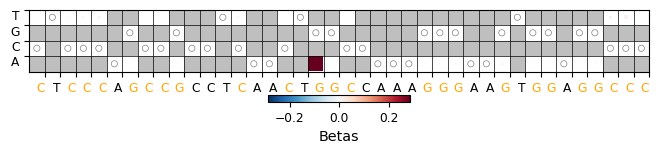

In [8]:
plot_millipede_heatmapV2('CD19_evoCDA_sigma_hit_table_everything.csv', 'presort_editing_freqs_avg_evoCDA_1_89_everything.csv' , 'wt_editing_freqs_avg_evoCDA_1_89_everything.csv')

In [176]:
millipede_dataframe_Betas_pivot, millipede_dataframe_PIPS_pivot, dfVariant = millipede_dataframe_cleanupV2('CD19_ABE8e_sigma_hit_table_everything.csv')
millipede_dataframe_Betas_pivot2, millipede_dataframe_PIPS_pivot2, dfVariant2 = millipede_dataframe_cleanupV2('CD19_evoCDA_sigma_hit_table_everything.csv')

dfVariantFinal = dfVariant + dfVariant2

# dfVariantFinal.head(40)

/tmp/ipykernel_194661/3535247635.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  millipede_dataframe_Betas['MainIndex'] = millipede_dataframe_Betas['MainIndex'].astype(float)
/tmp/ipykernel_194661/3535247635.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  millipede_dataframe_PIPS['MainIndex'] = millipede_dataframe['MainIndex'].astype(float)
/tmp/ipykernel_194661/3535247635.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [147]:
import logomaker
import pandas as pd

# Your DNA sequence
sequence = "ACATGCTCTAGTGAAAGCCAGTCTGGGCAGCTGGGTAGCTAATGAGGGGATTAGAGAGATTTTGTTGAATGAAAGGCAGATTGAGTCCTGCTACTCGCCCCCTTCATTCCCCTTCATTCATGCCTCATTCTTCCGCCTCCCAGCCGCCTCAACTGGCCAAAGGGAAGTGGAGGCCCTGCCACCTGTAGGGAGGGTCCCCTGGGGCTTGCCCACAGCAAACAGGAAGTCACAGCCTGGTGAGATGGGCCTGGGAATCAGCCACTGAGAAAGTGGGTCTCTTGGGTCCCTGAATTCTTTTTCTGAGTCCCTGCAGCAGTGAAAAAGACACAGAGGCACATAGAGAGTG"

# Create a DataFrame for one-hot encoding
one_hot_df = pd.DataFrame(0, index=range(len(sequence)), columns=['A', 'C', 'G', 'T'])

# Fill the DataFrame with one-hot encoding
for i, nucleotide in enumerate(sequence):
    one_hot_df.loc[i, nucleotide] = 0.25

one_hot_df

,A,C,G,T
0,0.25,0.00,0.00,0.00
1,0.00,0.25,0.00,0.00
2,0.25,0.00,0.00,0.00
3,0.00,0.00,0.00,0.25
4,0.00,0.00,0.25,0.00
...,...,...,...,...
341,0.00,0.00,0.25,0.00
342,0.25,0.00,0.00,0.00
343,0.00,0.00,0.25,0.00
344,0.00,0.00,0.00,0.25


In [148]:
SPIB = pd.read_csv('SPIB.txt', header = None, sep = ' ').dropna(axis=1)
SPIB.columns = ["A", "C", "G", "T"]
SPIB.index.name = "pos"
SPIB.to_csv('SPIBMain.txt', sep = '\t')


In [149]:
def reverse_complement_pfm(pfm):
    # reverse complement sequence
    revcomp = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}
    pfm_rc = pfm.copy()
    pfm_rc = pfm_rc.iloc[::-1, ::-1].rename(columns=revcomp, index=revcomp)
    return pfm_rc

# create empty dataframe with all values set to 0
PWM1 = pd.DataFrame(data=np.zeros((40, 4)), index=range(0, 40), columns=['A', 'C', 'G', 'T'])
SPIB_RC = reverse_complement_pfm(SPIB)
PWM1.iloc[11:27, :] = SPIB_RC

PWM2 = pd.DataFrame(data=np.zeros((40, 4)), index=range(0, 40), columns=['A', 'C', 'G', 'T'])
IKZF1 = pd.read_csv("IKZF1.txt", sep = "\t", index_col = 0)
PWM2.iloc[11:21, :] = IKZF1

PWM3 = pd.DataFrame(data=np.zeros((40, 4)), index=range(0, 40), columns=['A', 'C', 'G', 'T'])
PAX5V2 = pd.read_csv("PAX5V2.txt", sep = "\t", index_col = 0)
PAX5V2_RC = reverse_complement_pfm(PAX5V2)
PWM3.iloc[21:40, :] = PAX5V2_RC


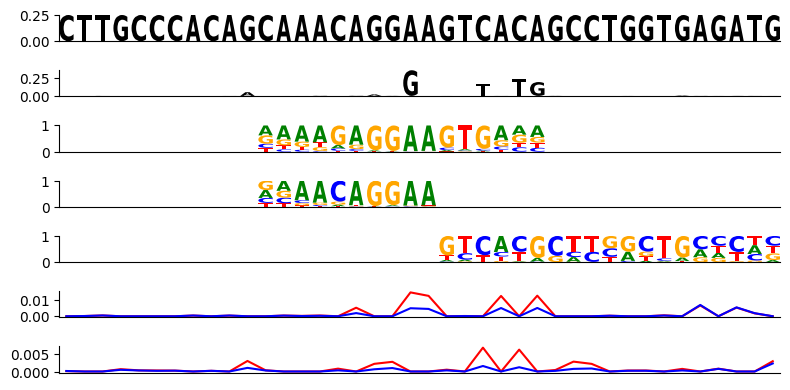

In [179]:
import matplotlib.pyplot as plt
import logomaker

dfVariantFinalPlot = dfVariantFinal.iloc[204:244,:]
one_hot_dfPlot = one_hot_df.iloc[204:244,:]

# Dimensions of the figure in inches
fig_width, fig_height = 8, 4  # Increase height to accommodate three plots
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(fig_width, fig_height), sharex=True)  

# Create the first sequence logo
seq_logo = logomaker.Logo(one_hot_dfPlot.reset_index(drop=True), ax=axes[0], color_scheme='black', width=0.8, center_values=False)
ars_logo = logomaker.Logo(dfVariantFinalPlot.reset_index(drop=True), ax=axes[1], color_scheme='black', width=0.8, center_values=False)
ars_logo1 = logomaker.Logo(PWM1, ax=axes[2], width=0.8, center_values=False)
ars_logo2 = logomaker.Logo(PWM2, ax=axes[3], width=0.8, center_values=False)
ars_logo3 = logomaker.Logo(PWM3, ax=axes[4], width=0.8, center_values=False)

enriched_editing_ABE = pd.read_csv("/data/pinello/PROJECTS/2023_08_CD19_manuscript/Core_Processing_Analysis/Analysis/ABE8e_Pooled_Endogenous_Redo_SecondAttempt_No_Contaminant_Millipede_Analysis/enriched_ABE8e_editing_efficiency.bedgraph", sep="\t", header=None, names = ["chr", "start", "stop", "editing"])
baseline_editing_ABE = pd.read_csv("/data/pinello/PROJECTS/2023_08_CD19_manuscript/Core_Processing_Analysis/Analysis/ABE8e_Pooled_Endogenous_Redo_SecondAttempt_No_Contaminant_Millipede_Analysis/baseline_ABE8e_editing_efficiency.bedgraph", sep="\t", header=None, names = ["chr", "start", "stop", "editing"])
enriched_editing_evoCDA = pd.read_csv("/data/pinello/PROJECTS/2023_08_CD19_manuscript/Core_Processing_Analysis/Analysis/ABE8e_Pooled_Endogenous_Redo_SecondAttempt_No_Contaminant_Millipede_Analysis/enriched_evoCDA_editing_efficiency.bedgraph", sep="\t", header=None, names = ["chr", "start", "stop", "editing"])
baseline_editing_evoCDA = pd.read_csv("/data/pinello/PROJECTS/2023_08_CD19_manuscript/Core_Processing_Analysis/Analysis/ABE8e_Pooled_Endogenous_Redo_SecondAttempt_No_Contaminant_Millipede_Analysis/baseline_evoCDA_editing_efficiency.bedgraph", sep="\t", header=None, names = ["chr", "start", "stop", "editing"])

editing_track = axes[5].plot(range(40), enriched_editing_ABE["editing"].iloc[204:244], color='red')
editing_track = axes[5].plot(range(40), baseline_editing_ABE["editing"].iloc[204:244], color='blue')
editing_track = axes[6].plot(range(40), enriched_editing_evoCDA["editing"].iloc[204:244], color='red')
editing_track = axes[6].plot(range(40), baseline_editing_evoCDA["editing"].iloc[204:244], color='blue')

# Remove spines and set x-ticks for each axis
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])

fig.savefig('Figure2HeatmapBottom.svg', format='svg')
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
